# Primitives

## Cosa sono?

«_The smallest processing instruction for a given abstraction level_»

The simplest building block you can give to a user to create something useful. In quantum computing, a user is generally interested in writing quantum algorithms without worrying about hardware details.


**Estimator Primitive:** 
Computes expectation values of observables with the respective states prepared by quantum circuits.

**Sampler Primitive:**
Returns _shot by shot_ bit strings sampled from the probability distribution of the quantum state prepared on the device. Per calcolare i valori di aspettazione poi bisogna fare del post-processing sui risultati.



In questa lezione vuole sostanzialmente implementare un circuito simile a quello utilizzato nell'articolo: 'evidence for the utility of quantum computing before fault tolerance'. Quello che ci serve è l'Hamiltoniano:

$$H = -J\sum_{\langle i,j\rangle} Z_i Z_j + h \sum_i X_i$$
Dove $Z$ e $X$ sono matrici di Pauli.

La dinamica degli spin da uno stato iniziale può essere simulata con una **decomposizione di Trotter al primo ordine** dell'operatore evoluzione temporale

$$\begin{cases}
e^{iH_{ZZ}\delta t} = \prod_{{\langle i,j\rangle}} e^{iJ\delta t Z_i Z_j} = \prod_{{\langle i,j\rangle}} R_{Z_i Z_j} (-2J\delta t)\\
e^{iH_{X}\delta t} = \prod_{i} e^{iJ\delta t X_i} = \prod_{i} R_{X_i} (-2h\delta t)\\
\end{cases}$$

L'evoluzione del tempo T è discretizzata in T/$\delta t$ steps.

La rotazione $R_{ZZ}$ si può scomporre in un circuito più semplice, composto da $S^\dagger$, $\sqrt{Y}$, CNOT e $\sqrt{Y}^\dagger$

# Transverse field Ising model to demo primitives

Creare una funzione che implementa un circuito con quell'hamiltoniano

In [44]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import YGate, UnitaryGate
import numpy as np

# Non c'è il SqrtYGate - ovvero la radice quadrata di Y - quindi lo creiamo noi a partire da YGate e un generico UnitaryGate
SqrtYGate = UnitaryGate(YGate().power(1/2), label=r"$\sqrt{Y}$")
# E facciamo anche l'aggiunto
SqrtYdgGate = UnitaryGate(SqrtYGate.inverse(), label=r"$\sqrt{Y}^\dagger$")

# trotter è una variabile aggiuntiva che rende le cose meno confuse? aggiunge delle barriere: cosa sono non l'ho capito
# sono delle semplicissime linee tratteggiate che rendono più leggibile la figura
def generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, num_classical_bits=0, trotter_barriers = False, layer_barriers = False): 
    if num_classical_bits == 0:
        qc = QuantumCircuit (num_qubits)
    else:
        qc = QuantumCircuit (num_qubits, num_classical_bits) # make sure it has a classical register

    for trotter_step in range (num_trotter_steps):
        add_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers)
        if trotter_barriers:
            qc.barrier()
    return qc

def add_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers = False):
    # Metto R_{ZZ} nei layer pari 
    for i in range(0, qc.num_qubits-1, 2): # da 0 al n-1 con passo 2 --> quindi solo qubit pari
        qc.sdg([i, i+1]) # sdg: S dagato
        qc.append(SqrtYGate, [i+1]) 
        qc.cx(i, i+1) # cx: CNOT
        qc.append(SqrtYdgGate, [i+1])
    if layer_barriers:
        qc.barrier()
    # Metto R_{ZZ} nei layer dispari 
    for i in range(1, qc.num_qubits-1, 2): # da 1 al n-1 con passo 2 --> quindi solo qubit dispari
        qc.sdg([i, i+1]) # sdg: S dagato
        qc.append(SqrtYGate, [i+1]) 
        qc.cx(i, i+1) # cx: CNOT
        qc.append(SqrtYdgGate, [i+1])
    if layer_barriers:
        qc.barrier()
    # Applico R_X a tutti
    qc.rx(rx_angle, list(range(qc.num_qubits)))
    if layer_barriers:
        qc.barrier()
    

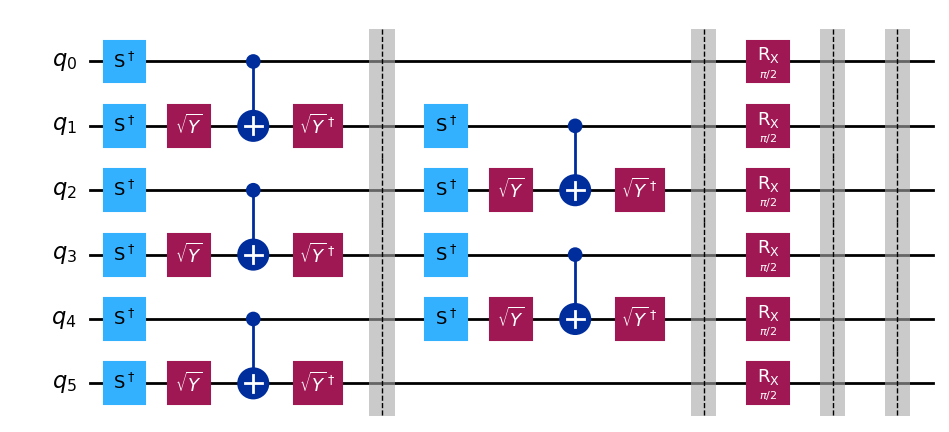

In [45]:
# questo è un test per vedere se funziona tutto
num_qubits = 6
num_trotter_steps = 1 # praticamente ogni step è uno di quei circuiti, quindi fa num_trotter_steps circuiti uno in fila all'altro
rx_angle = 0.5 * np.pi

qc = generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, trotter_barriers=True, layer_barriers=True)
qc.draw(output='mpl', fold=1)

«Next step is starting to implement this for the sampler»


## Demo: Sampler

Abbiamo implementato un circuito per il tempo che va in avanti, va creato anche in modo che vada all'indietro 
Il modo più diretto per farlo è creare una funzione che implementa un circuito inverso a quello già creato, che poi va attaccato a quello di prima

In [46]:
def append_mirrored_1d_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers = False, layer_barriers = False): 

    for trotter_step in range (num_trotter_steps):
        add_mirrored_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers)
        if trotter_barriers:
            qc.barrier()

def add_mirrored_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers = False):
    # Applico R_X a tutti
    qc.rx(-rx_angle, list(range(qc.num_qubits))) #invertito quindi con angolo di segno opposto
    if layer_barriers:
        qc.barrier()
    # Metto R_{ZZ} nei layer dispari - vanno tutti invertiti di ordine 
    for i in range(1, qc.num_qubits-1, 2):
        qc.append(SqrtYdgGate, [i+1])
        qc.cx(i, i+1) # cx: CNOT questo non viene invertito?
        qc.append(SqrtYGate, [i+1]) 
        qc.s([i, i+1]) # S è inverso di S dagato 
    if layer_barriers:
        qc.barrier()

    # Metto R_{ZZ} nei layer pari - vanno tutti invertiti di ordine 
    for i in range(0, qc.num_qubits-1, 2):
        qc.append(SqrtYdgGate, [i+1])
        qc.cx(i, i+1) # cx: CNOT questo non viene invertito?
        qc.append(SqrtYGate, [i+1]) 
        qc.s([i, i+1]) # S è inverso di S dagato 
    if layer_barriers:
        qc.barrier()    


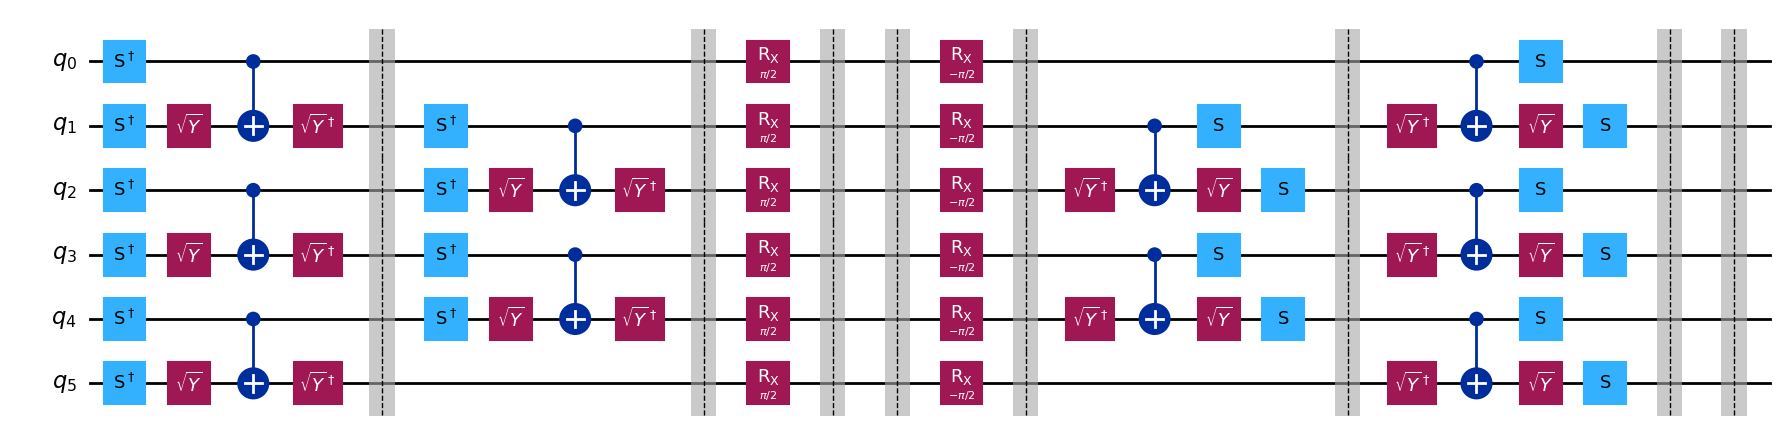

In [47]:
# prendiamo quello originale e attacchiamo quello specchiato con la funzione appena scritta

append_mirrored_1d_tfim_circuit (qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers=True, layer_barriers=True) 
qc.draw(output='mpl', fold=-1)


$R_x$ successive con gli angoli specchiati danno l'identità e così via tutte le altre, quindi se parto con tutti |0> mi aspetto di trovare tutti |0> alla fine. Il risultato finale è semplicemente l'operatore identità.

Ora si inizia con gli step già citati: mappare circuiti e operatori, creare le osservabili, eseguire su hardware, plottare e post-processare. Vogliamo incrementare il numero di trotter steps del circuito, invertendo ogni singolo step e vedendo la probabilità di sopravvivenza (?)

## Step 1: mapping problem to circuits and observables

In [51]:
max_trotter_steps = 10
num_qubits = 100
measured_qubits = [49, 50] # siamo interessati a vedere i due qubit centrali

qc_list = [] # creo un vettore vuoto: dentro ci vanno tutti i circuiti
for trotter_step in range (max_trotter_steps):
    qc = generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, num_classical_bits=len(measured_qubits), trotter_barriers=True, layer_barriers=True) # faccio il circuito 
    append_mirrored_1d_tfim_circuit (qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers=True, layer_barriers=True) # appendo quello specchiato

    qc.measure(measured_qubits, list(range(len(measured_qubits)))) # crea una lista di lunghezza flessibile in base ai qubit misurati (quindi classici)
    qc_list.append(qc)



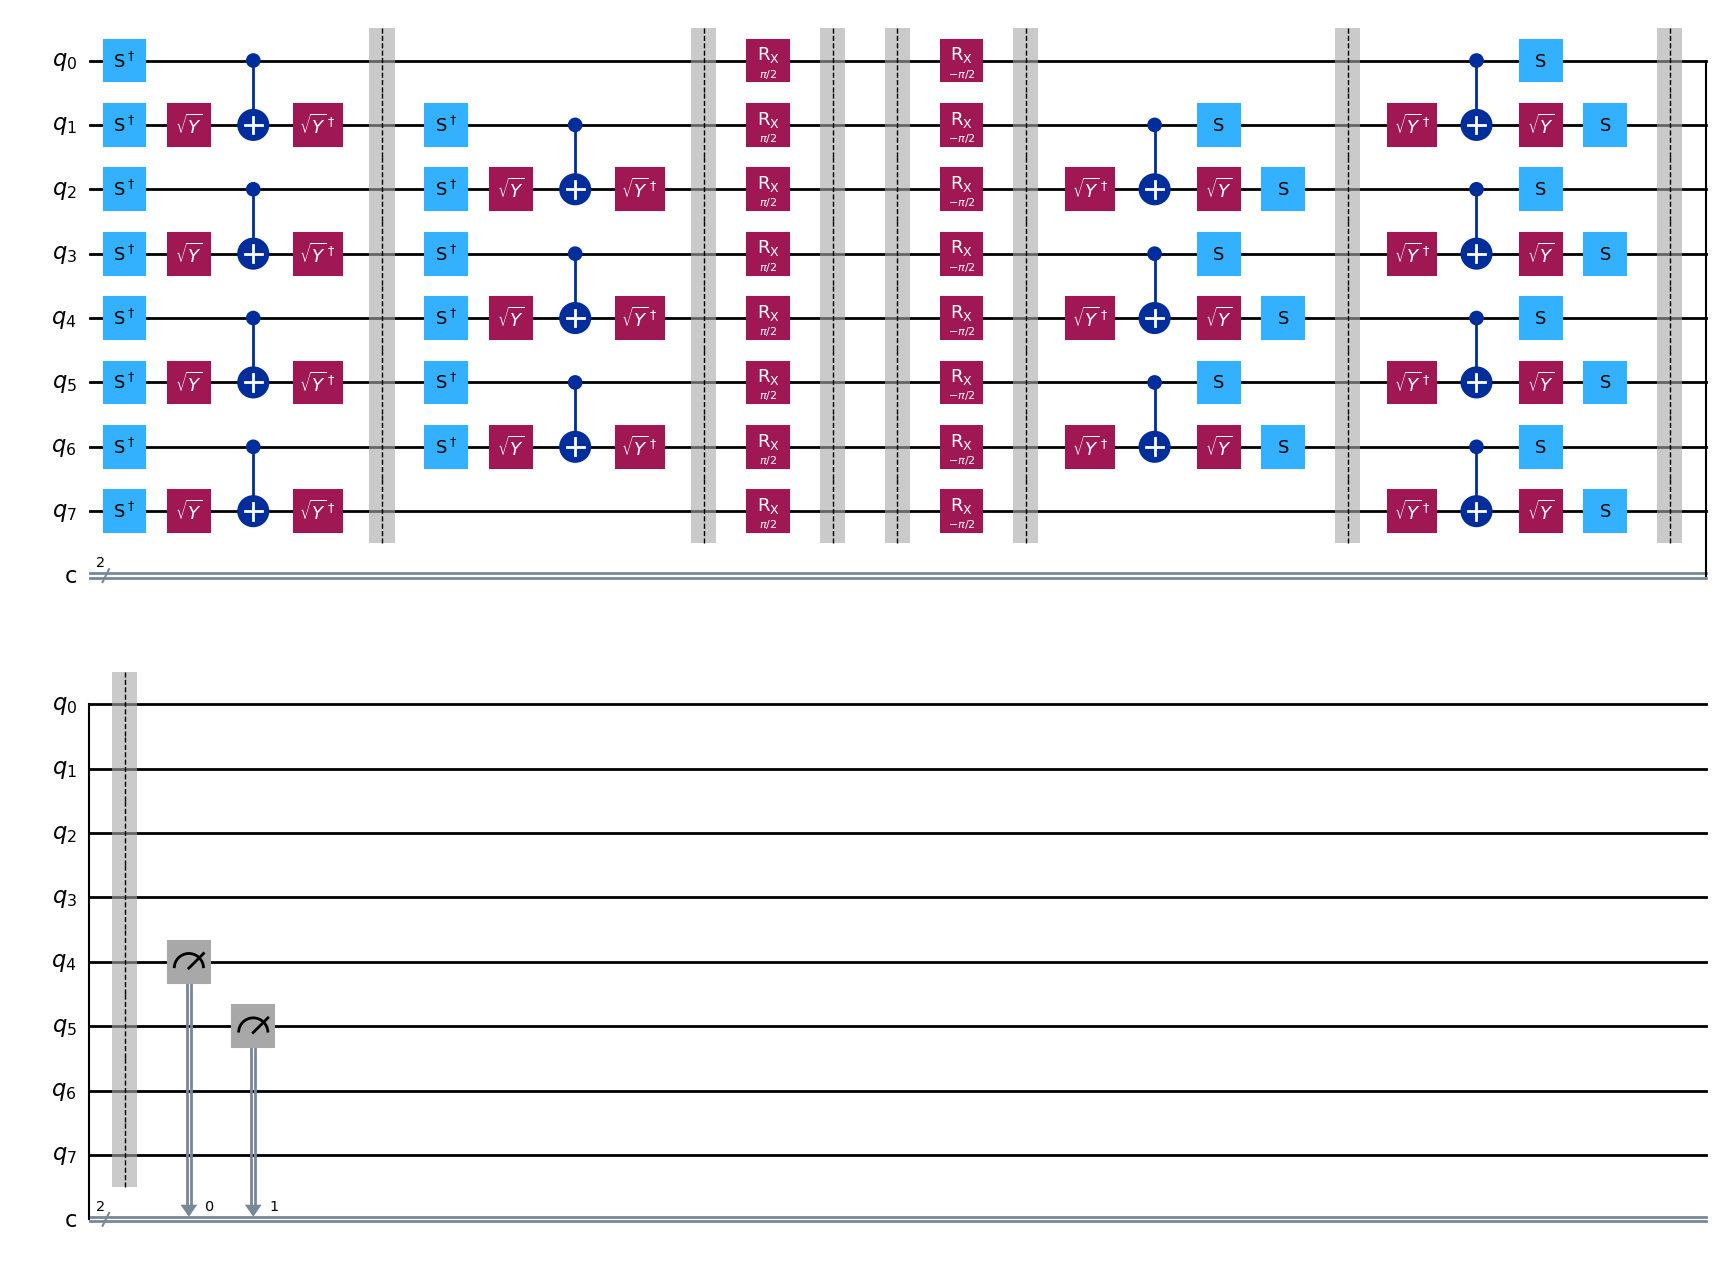

In [49]:
# per vedere se funziona visualizziamo il primo circuito, ma con 10 trotter steps e 8 qubit
# qc_list[1].draw(output='mpl')

## Step 2: Ottimizzare

In [53]:
from qiskit import transpile # questa quindi è una funzione che ottimizza da sola il circuito
# prende in argomento il backend che usi, quindi probabilmente fa un'ottimizzazione ad hoc per quello
from qiskit_ibm_runtime import QiskitRuntimeService

backend_name = "ibm_brisbane"
service = QiskitRuntimeService()
backend = service.backend(backend_name)

qc_transplanted_list = transpile (qc_list, backend=backend, optimization_level=1) # ma il livello? cosa significa?


## Step 3: Excecuting on hardware

In [57]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.options.sampler_options import SamplerOptions 

sampler = Sampler(mode=backend)

# ci si aspetta un alto tempo di esecuzione quindi attiva questa opzione e la tipologia
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"

job = sampler.run(qc_transplanted_list)
print(job.job_id())

cvtsj5gbtzcg008mxphg


## Step 4: Post-Processing & Plotting (che potrò fare solo una volta che sarà stato eseguito)

In [ ]:
job_id = "cvtsj5gbtzcg008mxphg"
job = service.job(job_id)

survival_probability_list = [] # voglio vedere se effettivamente i bit sono rimasti invariati

# ad ogni evoluzione temporale (trotter step) vedo se sono sopravvissuti

for trotter_step in range(max_trotter_steps):
    try:
        data = job.result()[trotter_step].data
        survival_probability_list.append(data.c.get_counts()['0' * len(measured_qubits)] / data.c.num_shots)
    except:
        survival_probability_list.append(0)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(list[range(0, 4 * max_trotter_steps, 4)], survival_probability_list, '--o') # o è il marker
plt.xlabel('2Q gate Depth')
plt.ylabel('Survival probability of the all-0 bit string')
plt.xsticks(np.arange(0, 44, 4))
plt.show()

Man mano che si procede con gli steps la survival probability diminuisce da 1 a 0.2 in 40 step. Questo mostra che i risultati sono comunque abbastanza promettenti.

# Estimator 

Vuole imitare una cosa che hanno fatto nell'articolo: 

## Step 1: mappare il problema

Estimator e sampler hanno funzionalità potenti che permettono di parametrizzare dei gates e sweep 'spazzare' tutti quanti insieme senza dover generare un circuito per ciascuno. Ora mostra come si fa.

In [59]:
from qiskit.circuit import Parameter

rx_angle = Parameter ("rx_angle") 
trotter_steps = 2
qc = generate_1d_tfim_circuit (num_qubits, trotter_steps, rx_angle) 

# map it into operators
from qiskit.quantum_info import SparsePauliOp
 
middle_index = num_qubits // 2 # restituisce la parte intera
observable = SparsePauliOp("I" * middle_index + "Z" + "I" * (middle_index-1))



## Step 2: Ottimizzare il circuito - fa la stessa cosa di ep3

In [62]:
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService

backend_name = 'ibm_brisbane'
service = QiskitRuntimeService()
backend = service.backend(backend_name)

qc_transpiled = transpile (qc, backend=backend, optimization_level=1)
observable = observable.apply_layout(qc_transpiled.layout)


## Step 3: Eseguire su hardware

In [64]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import EstimatorOptions

min_rx_angle = 0
max_rx_angle = np.pi/2
num_rx_angle = 12
rx_angle_list = np.linspace(min_rx_angle, max_rx_angle, num_rx_angle)

options = EstimatorOptions()
options.resilience_level = 1
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XY4"

estimator = Estimator (mode=backend)

job = estimator.run ([(qc_transpiled, observable, rx_angle_list)])
print (job.job_id())



cvtt8rkbm6rg008jh01g


## Step 4: Post-processing & plotting

(-0.1, 1.1)

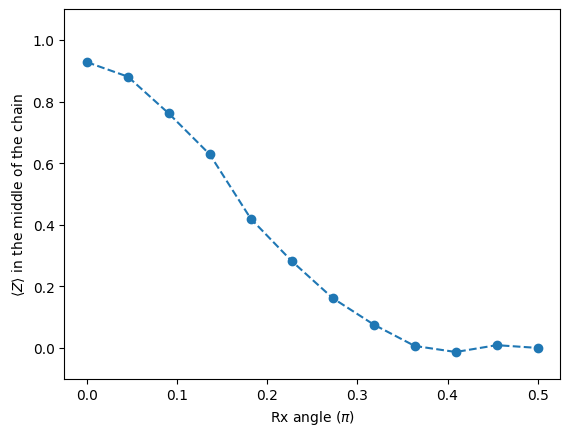

In [67]:
import matplotlib.pyplot as plt
job_id = "cvtt8rkbm6rg008jh01g"

job = service.job(job_id)

exp_val_list = job.result()[0].data.evs

plt.plot(rx_angle_list / np.pi, exp_val_list, '--o')
plt.xlabel(r'Rx angle ($\pi$)')
plt.ylabel(r'$\langle Z \rangle$ in the middle of the chain')
plt.ylim(-0.1, 1.1)
